# 1 Introduction to Convolutional Neural Networks (CNNs) (Quick Recap)

### Why Use CNNs for Computer Vision?

1. **Parameter Sharing**: CNNs use convolutional filters to scan the input image, which greatly reduces the number of parameters, making the network easier to train.
2. **Local Connectivity**: Each neuron is connected to only a local region of the input, capturing local patterns effectively.
3. **Translation Invariance**: Due to the sliding filter operation, CNNs can detect patterns regardless of their position in the image.
4. **Hierarchical Feature Learning**: CNNs learn hierarchical features, with lower layers capturing simple patterns and deeper layers capturing more complex patterns

### 1.1 Why do we need to understand this?

1. **Model parameters** $\longrightarrow$ How many params will model have if we'll use this conv layer, and what if we'll use 3 conv layers of one type, 10 of second type and 20 of third one? We can theoretically compute and analyze this things without any additional tools
2. **$\Delta H, \Delta W, \Delta C$** $\longrightarrow$ What will happen to the image after going through this conv layer? Especially important when you want to stack **a lot** of them one after another or create atypical architecture
3. **Receptive field** $\longrightarrow$ How to interpret model results and find what went wrong, or how exactly model solved the case? How big of a patterns model can phisically capture?
4. **It's not just magic!** $\longrightarrow$ **It's cooler, it's mathematical magic!!!** And you can calculate and compute it in any way you want

### 1.2 Conv layer params

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

input: $H \times W \times C_{in}$

1. Kernel\_size $\longrightarrow$ [$K_{h} \times K_{w}$]
2. Input and output channels $\longrightarrow$ [$C_{in}$, $C_{out}$]
3. Padding $\longrightarrow$ how much zeroes (or other specified elements) should be added on each side of the image [$P$, default 0]
4. Stride $\longrightarrow$ distance between two adjacent positions of the kernel on the original image [$S$, default 1]
5. Dilation $\longrightarrow$ distance between each two adjacent elements inside the kernel [$D$, default 1]
6. Bias $\longrightarrow$ linear addition to each output channel [$B$, default True]

output: $H' \times W' \times C_{out}$

### 1.3 Model parameters

Depends on $K_h, K_w, C_{in}, C_{out}, B$

Actual kernel, moving across the image, has size $K_h \times K_w \times C_{in}$. Then, for each output channel we have one **different** kernel of this size and one bias value, if $B = \text{true}$

So, weights, corresponding to one convolutional layers are: $$((K_h * K_w * C_{in}) + B) * C_{out}$$

### 1.4 Receptive field

How much of a pattern model can possibly see? 

If convolutional model has only one layer, then the biggest possible pattern that model can capture is $K_h \times K_w$

If we'll use many small kernels consecutively, the last layer will be able to capture a patterns way bigger then it's kernel size. Receptive field - zone, from which a particular neuron actually takes information

And... that's exactly the reason why we **STACK MORE LAYERS!!!** $\longrightarrow$ it's just cheaper and more effective to have few small kernels, instead of one big

# 2 Conv under the hood (well almost)

In [43]:
import numpy as np

In [44]:
class Module(object):
    """
    Basically, you can think of a module as of a something (black box)
    which can process `input` data and produce `ouput` data.
    This is like applying a function which is called `forward`:

        output = module.forward(input)

    The module should be able to perform a backward pass: to differentiate the `forward` function.
    Moreover, it should be able to differentiate it if is a part of chain (chain rule).
    The latter implies there is a gradient from previous step of a chain rule.

        input_grad = module.backward(input, output_grad)
    """
    def __init__ (self):
        self._output = None
        self._input_grad = None
        self.training = True

    def forward(self, input):
        self._output = self._compute_output(input)
        return self._output

    def backward(self, input, output_grad):
        self._input_grad = self._compute_input_grad(input, output_grad)
        self._update_parameters_grad(input, output_grad)
        return self._input_grad


    def _compute_output(self, input):
        raise NotImplementedError


    def _compute_input_grad(self, input, output_grad):
        raise NotImplementedError

    def _update_parameters_grad(self, input, output_grad):
        pass

    def zero_grad(self):
        pass

    def get_parameters(self):
        return []

    def get_parameters_grad(self):
        return []

    def train(self):
        self.training = True

    def evaluate(self):
        self.training = False

    def __repr__(self):
        return "Module"

In [45]:
from scipy.signal import correlate


class Conv2d(Module):
    """
    * input: `batch_size x in_channels x h x w`
    * output: `batch_size x out_channels x h x w`
    You should implement something like pytorch Conv2d layer with `stride=1` and zero-padding outside of image using `scipy.signal.correlate` function.
    **Practical notes:**
    * While the layer name is "convolution", the most of neural network frameworks (including tensorflow and pytorch)
    implement operation that is called [correlation](https://en.wikipedia.org/wiki/Cross-correlation#Cross-correlation_of_deterministic_signals) in signal processing theory.
    So don't use `scipy.signal.convolve` since it implements convolution in terms of signal processing.
    * It may be convenient to use numpy.pad for zero-padding.
    * It's rather ok to implement convolution over 4d array using 2 nested loops: one over batch size dimension and another one over output filters dimension
    """
    def __init__(self, in_channels, out_channels, kernel_size):
        """
        Initializes a 2D convolutional layer.

        :param in_channels: Number of channels in the input image.
        :param out_channels: Number of filters in the convolutional layer.
        :param kernel_size: Size of each filter. Assumes a square filter.
        """
        super(Conv2d, self).__init__()
        # Ensuring the kernel size is odd to preserve spatial dimensions after convolution.
        assert kernel_size % 2 == 1, kernel_size

        # Initialize weights and biases
        stdv = 1./np.sqrt(in_channels)
        self.W = np.random.uniform(-stdv, stdv, size = (out_channels, in_channels, kernel_size, kernel_size))
        self.b = np.random.uniform(-stdv, stdv, size=(out_channels,))
        
        # Storing layer parameters
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        
        # Gradients initialization
        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)

    def _compute_output(self, input):
        """
        Applies the convolutional layer to the input.

        :param input: Input image batch of shape (batch_size, in_channels, height, width).
        :return: Output feature map of shape (batch_size, out_channels, height, width).
        """
        # Calculate padding size and output dimensions
        pad_size = self.kernel_size // 2
        batch_size, _, H, W = input.shape
        
        # 1. Apply zero-padding to the input image
        padding_params = ((0, 0), (0, 0), (pad_size, pad_size), (pad_size, pad_size))
        padded_input = np.pad(input, padding_params)
        # 2. compute convolution using scipy.signal.correlate(... , mode='valid')
        # because of same-padding H_in = H_out, W_in = W_out
        out_shape = (batch_size, self.out_channels, H, W)
        self._output = np.zeros(shape=out_shape)
        
        # Loop over the batch and channels to perform the convolution operation
        
        
        return self._output

    def _compute_input_grad(self, input, gradOutput):
        pad_size = self.kernel_size // 2
        # 1. zero-pad the gradOutput
        padding_params = ((0, 0), (0, 0), (pad_size, pad_size), (pad_size, pad_size))
        padded_gradOutput = np.pad(gradOutput, padding_params)
        # 2. compute 'self._input_grad' value using scipy.signal.correlate(... , mode='valid')
        self._input_grad = np.zeros(shape=input.shape)

        return self._input_grad

    def accGradParameters(self, input, gradOutput):
        pad_size = self.kernel_size // 2
        # 1. zero-pad the input
        padding_params = ((0, 0), (0, 0), (pad_size, pad_size), (pad_size, pad_size))
        padded_input = np.pad(input, padding_params)
        # 2. compute 'self.gradW' using scipy.signal.correlate(... , mode='valid')
        self.gradW = np.zeros(self.W.shape)

        # 3. compute 'self.gradb' - formulas like in Linear of ChannelwiseScaling layers
        self.gradb = np.sum(gradOutput, axis=(0, 2, 3))

    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)

    def getParameters(self):
        return [self.W, self.b]

    def getGradParameters(self):
        return [self.gradW, self.gradb]

    def __repr__(self):
        s = self.W.shape
        q = 'Conv2d %d -> %d' %(s[1],s[0])
        return q

In [46]:
import torch
import torch.nn as nn
import numpy as np

# Assuming 'Conv2d' is the custom convolution class provided earlier

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Input dimensions and parameters
batch_size, in_channels, height, width = 1, 3, 5, 5
out_channels, kernel_size = 2, 3

# Initialize custom Conv2d layer
custom_conv = Conv2d(in_channels, out_channels, kernel_size)

# Initialize PyTorch Conv2d layer
torch_conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size//2, bias=True)

# Ensure same weights and biases
custom_weights = custom_conv.W.copy()  # Convert to [kernel_size, kernel_size, in_channels, out_channels] and then copy to ensure C-contiguous array
custom_bias = custom_conv.b.copy()

with torch.no_grad():
    torch_conv.weight.copy_(torch.from_numpy(custom_weights).float())
    torch_conv.bias.copy_(torch.from_numpy(custom_bias).float())

# Create random input tensor
input_tensor = np.random.rand(in_channels, height, width).astype(np.float32)
input_var = torch.tensor(input_tensor)


# Get outputs
custom_output = custom_conv.forward(np.array([input_tensor]))
torch_output = torch_conv(input_var).detach().numpy()

# Compare outputs
difference = np.abs(custom_output - torch_output)

print(f"Max diff between our Conv2d and PyTorch Conv2d:{np.max(difference)}")
assert np.allclose(custom_output, torch_output, atol=1e-6)


Max diff between our Conv2d and PyTorch Conv2d:1.774747651062114e-07


## 3 Conv Net

In [3]:
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms as tr

In [4]:
class MyDataset(Dataset):
    def __init__(self):
        pass
    
    def __len__(self):
        pass
    
    def __getitem__(self, idx):
        pass

### 3.1 Downloading data

Downloading different datasets using https://pytorch.org/vision/stable/datasets.html

In [8]:
from torchvision import datasets
from IPython.display import clear_output
import os
from datetime import datetime 

download_dir = './datasets'

all_datasets = [
    'CIFAR10',
    # 'CIFAR100',
    # 'FashionMNIST',
    # 'KMNIST',
    # 'MNIST',
    # 'STL10',
    # 'SVHN',
#     'CelebA'
]

val_data = dict()
data = dict()
download_time = dict()
for i, dataset_name in enumerate(all_datasets):
    clear_output(True)
    start_time = datetime.now() 
    
    print(f'{i+1}/{len(all_datasets)}: Downloading dataset {dataset_name}')
    
    download = not os.path.isdir(f'{download_dir}/{dataset_name}')
    download_exec = f'data[dataset_name] = datasets.{dataset_name}(root=\'{os.path.join(download_dir, dataset_name)}\', download={download})'
    if dataset_name not in {'CelebA', 'STL10', 'SVHN'}:
        download_val_exec = f'val_data[dataset_name] = datasets.{dataset_name}(root=\'{os.path.join(download_dir, dataset_name)}\', download={download}, train=False)'
    else:
        download_val_exec = f'val_data[dataset_name] = datasets.{dataset_name}(root=\'{os.path.join(download_dir, dataset_name)}\', download={download}, split=\'test\')'
    
    # NEVER REPEAT THIS AT HOME
    exec(download_exec)
    exec(download_val_exec)
    download_time[dataset_name] = datetime.now() - start_time

clear_output(True)
print('Download time:')
for k, v in download_time.items():
    print('{: <12} ~ {}'.format(k, v))

Download time:
CIFAR10      ~ 0:00:00.457154


### Let's look on our data

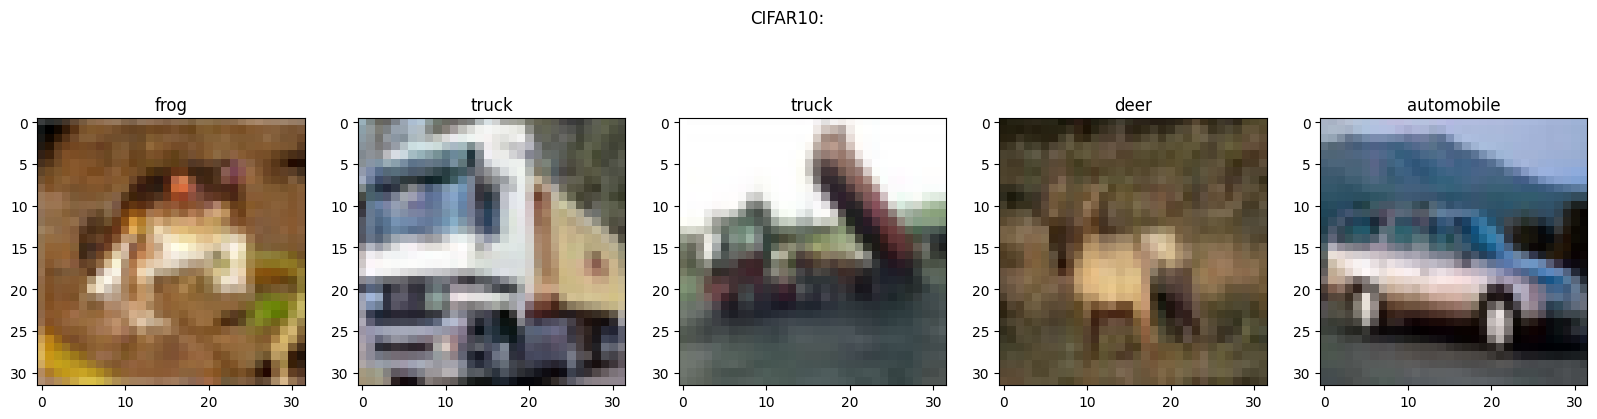

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

h = 1
w = 5

for dataset_name in data:    
    fig, ax = plt.subplots(h, w, figsize=(20, 5 * h))
    fig.suptitle(f'{dataset_name}:')
    for i, el in enumerate(data[dataset_name]):
        if i >= h * w:
            break
        plt.subplot(h, w, i + 1)
        plt.imshow(el[0])
        if isinstance(el[1], int):
            try:
                plt.title(data[dataset_name].classes[el[1]])
            except:
                plt.title(el[1])
    plt.show()

### Making dataloaders

In [10]:
class AddTransformsDataset:
    # Class to add custom transforms to any dataset (except 'CelebA') before creating dataloader
    def __init__(self, dataset, transforms=None):
        self.dataset = dataset
        self.transforms = transforms
        
        # Getting classes from dataset
        if hasattr(self.dataset, 'classes'):
            self.clss = self.dataset.classes
        else:
            self.clss = [i for i in range(10)]
    
    def __len__(self) -> int:
        return self.dataset.__len__()
    
    def classes(self):
        return self.clss
    
    def __getitem__(self, index: int):
        image, label = self.dataset.__getitem__(index)
        if self.transforms:
            image = self.transforms(image)
        return image, label

In [11]:
from torchvision import transforms as tr
from torch.utils.data import DataLoader

def my_transform():
    return tr.Compose([
        tr.ToTensor(),
    ])

def make_dataloaders(data, batch_size=16, transform_function=None, datasets_to_exclude=set(), val=False):
    dataloaders = dict()
    classes = dict()
    if isinstance(datasets_to_exclude, (str, list, tuple)):
        datasets_to_exclude = set(datasets_to_exclude)
    
    for dataset_name in data.keys() - {'CelebA'} - datasets_to_exclude:
        ds = AddTransformsDataset(data[dataset_name], transform_function())
        dataloaders[dataset_name] = DataLoader(
            ds,
            batch_size=batch_size,
            shuffle=(not val),
            drop_last=(not val)
        )
        classes[dataset_name] = ds.classes()
    return dataloaders, classes

In [12]:
dataloaders, classes = make_dataloaders(data, 16, my_transform)
val_dataloaders, _ = make_dataloaders(val_data, 16, my_transform, val=True)

In [13]:
dataloaders.keys()

dict_keys(['CIFAR10'])

In [14]:
for dataset_name in dataloaders:
    imgs_batch, lbls_batch = next(iter(dataloaders[dataset_name]))
    print(f'shapes for {dataset_name}:\n--images_batch: {imgs_batch.shape},\n--labels_batch: {lbls_batch.shape}\n')

shapes for CIFAR10:
--images_batch: torch.Size([16, 3, 32, 32]),
--labels_batch: torch.Size([16])



### Optimizer

In [16]:
import torch
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

def create_model_and_optimizer(model_class, model_params, lr=1e-3, beta1=0.9, beta2=0.999, device=device):
    model = model_class(**model_params)
    model = model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr, [beta1, beta2])
    return model, optimizer

In [17]:
import torch.nn.functional as F
from tqdm.notebook import tqdm

criterion = nn.NLLLoss()

def train(model, optimizer, loader, criterion):
    model.train()
    losses_tr = []
    for images, targets in tqdm(loader):
        images = images.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        out = model(images)
        loss = criterion(out, targets)
        
        loss.backward()
        optimizer.step()
        losses_tr.append(loss.item()) 
    
    return model, optimizer, np.mean(losses_tr)

def val(model, loader, criterion):
    model.eval()
    losses_val = []
    with torch.no_grad():
        for images, targets in tqdm(loader):
            images = images.to(device)
            targets = targets.to(device)
            out = model(images)
            loss = criterion(out, targets)

            losses_val.append(loss.item())
    
    return np.mean(losses_val)

In [19]:
def real_confusion_matrix(model, val_loader, class_labels, use_probs=False, normalize=True):
    with torch.no_grad():
        n_classes = len(class_labels)
        conf_matrix = np.zeros((n_classes, n_classes))
        for i, (images, labels) in enumerate(tqdm(val_loader)):
            probs = model(images.to(device)).exp()
            if use_probs:
                for j in range(images.shape[0]):
                    for c in range(n_classes):
                        conf_matrix[labels[j].item(), c] += probs[j,c]
            else:
                _, pred_classes = torch.max(probs, 1)
                for j in range(images.shape[0]):
                    conf_matrix[labels[j].item(), pred_classes[j].item()] += 1.
        
        if normalize:
            conf_matrix /= conf_matrix.sum(1)
        
        fig = plt.figure(figsize=(18, 10))
        fig.suptitle(f'Confusion matrix (norm={normalize}, use_probs={use_probs})')
        ax = fig.add_subplot(111)
        cax = ax.matshow(conf_matrix)
        fig.colorbar(cax)
        
        ax.xaxis.set_major_formatter('')
        secax = ax.secondary_xaxis('top')
        secax.xaxis.set_ticks(list(range(len(class_labels))))
        secax.xaxis.set_ticklabels(class_labels)
        secax.set_xlabel('predicted class')
        
        ax.yaxis.set_ticks(list(range(len(class_labels))))
        ax.yaxis.set_ticklabels(class_labels)
        ax.set_ylabel('true class')
        
        plt.show()
        
        return conf_matrix

In [20]:
import numpy as np
from torch import nn
from collections import OrderedDict

class conv_net(nn.Module):
    """
        Simple convolutional network
    """
    def __init__(self, input_size, num_layers, kernel_sizes, hidden_sizes, activations, dropouts, output_size):
        super(conv_net, self).__init__()
        
        if not isinstance(kernel_sizes, list):
            kernel_sizes = 
        assert len(kernel_sizes) == num_layers, f'provide {num_layers} kernel_sizes or just one for all layers'
        
        if not isinstance(hidden_sizes, list):
            hidden_sizes = 
        assert len(hidden_sizes) == num_layers, f'provide {num_layers} hidden_sizes or just one for all layers'
        
        if not isinstance(activations, list):
            activations = 
        assert len(activations) == num_layers, f'provide {num_layers} activation functions or just one for all layers'
        
        if not isinstance(dropouts, list):
            dropouts = 
        assert len(dropouts) == num_layers, f'provide {num_layers} dropout values or just one for all layers'
        
        in_conv = ('conv_0', nn.Conv2d(input_size[0], hidden_sizes[0], kernel_sizes[0], padding=(kernel_sizes[0]-1)//2))
        
        conv_blocks_ = [[
            (f'act_{i+1}', activations[i]),
            (f'drop_{i+1}', nn.Dropout(dropouts[i])),
            (f'conv_{i+1}', nn.Conv2d(hidden_sizes[i], hidden_sizes[i+1], kernel_sizes[i+1], padding=(kernel_sizes[i+1]-1)//2))
        ] for i in range(num_layers-1)]
        conv_blocks = []
        for el in conv_blocks_:
            conv_blocks.extend(el)
        
        head = [
            (f'act_{num_layers}', activations[-1]),
            (f'drop_{num_layers}', nn.Dropout(dropouts[-1])),
            ('flat', nn.Flatten()),
            ('hid2out', nn.Linear(input_size[1] * input_size[2] * hidden_sizes[-1], output_size)),
            ('log-softmax', nn.LogSoftmax(dim=-1))
        ]
        
        self.net = [in_conv, *conv_blocks, *head]
        self.net = nn.Sequential(OrderedDict(self.net))
    
    def forward(self, imgs):
        return self.net(imgs)

In [21]:
# Example for CIFAR10
model_conv = conv_net(
    input_size = (3, 32, 32),
    num_layers = 3,
    kernel_sizes = 5,
    hidden_sizes = [16, 16, 8],
    activations = nn.Tanh(),
    dropouts = 0.2,
    output_size = 10
)

print('Model:', model_conv, sep='\n')

imgs_batch, lbls_batch = next(iter(dataloaders['CIFAR10']))

print(f'\nInput shape: {imgs_batch.shape}')
out = model_conv(imgs_batch)
print(f'Output shape: {out.shape}')

print(f'\nChecking that returned probabilities (all sums must be close to 1)', out.exp().sum(-1).detach().numpy(), sep='\n')

Model:
conv_net(
  (net): Sequential(
    (conv_0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (act_1): Tanh()
    (drop_1): Dropout(p=0.2, inplace=False)
    (conv_1): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (act_2): Tanh()
    (drop_2): Dropout(p=0.2, inplace=False)
    (conv_2): Conv2d(16, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (act_3): Tanh()
    (drop_3): Dropout(p=0.2, inplace=False)
    (flat): Flatten(start_dim=1, end_dim=-1)
    (hid2out): Linear(in_features=8192, out_features=10, bias=True)
    (log-softmax): LogSoftmax(dim=-1)
  )
)

Input shape: torch.Size([16, 3, 32, 32])
Output shape: torch.Size([16, 10])

Checking that returned probabilities (all sums must be close to 1)
[1.         1.         1.         1.0000001  0.99999994 1.0000001
 0.9999999  1.0000001  0.99999994 0.99999994 0.9999999  1.0000001
 0.99999994 1.0000002  0.99999994 1.0000001 ]


### Learning loop

In [29]:
from IPython.display import clear_output
from tqdm.notebook import trange


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

def learning_loop(model, optimizer, train_loader, val_loader, criterion, scheduler=None, min_lr=None, epochs=10, val_every=1, draw_every=1, separate_show=False):
    losses = {'train': [], 'val': []}

    for epoch in range(1, epochs+1):
        print(f'#{epoch}/{epochs}:')
        model, optimizer, loss = train(model, optimizer, train_loader, criterion)
        losses['train'].append(loss)

        if not (epoch % val_every):
            loss = val(model, val_loader, criterion)
            losses['val'].append(loss)
            if scheduler:
                scheduler.step(loss)

        if not (epoch % draw_every):
            clear_output(True)
            fig, ax = plt.subplots(1, 2 if separate_show else 1, figsize=(20, 10))
            fig.suptitle(f'#{epoch}/{epochs}:')

            if separate_show:
                plt.subplot(121)
                plt.title('loss on train')
            plt.plot(losses['train'], 'r.-', label='train')
            plt.legend()

            if separate_show:
                plt.subplot(122)
                plt.title('loss on validation')
            else:
                plt.title('losses')
            plt.plot(losses['val'], 'g.-', label='val')
            plt.legend()
            
            plt.show()
        
        if min_lr and get_lr(optimizer) <= min_lr:
            print(f'Learning process ended with early stop after epoch {epoch}')
            break
    
    return model, optimizer, losses

In [30]:
model_params = dict()
model = dict()
optimizer = dict()
scheduler = dict()
criterion = dict()
losses = dict()

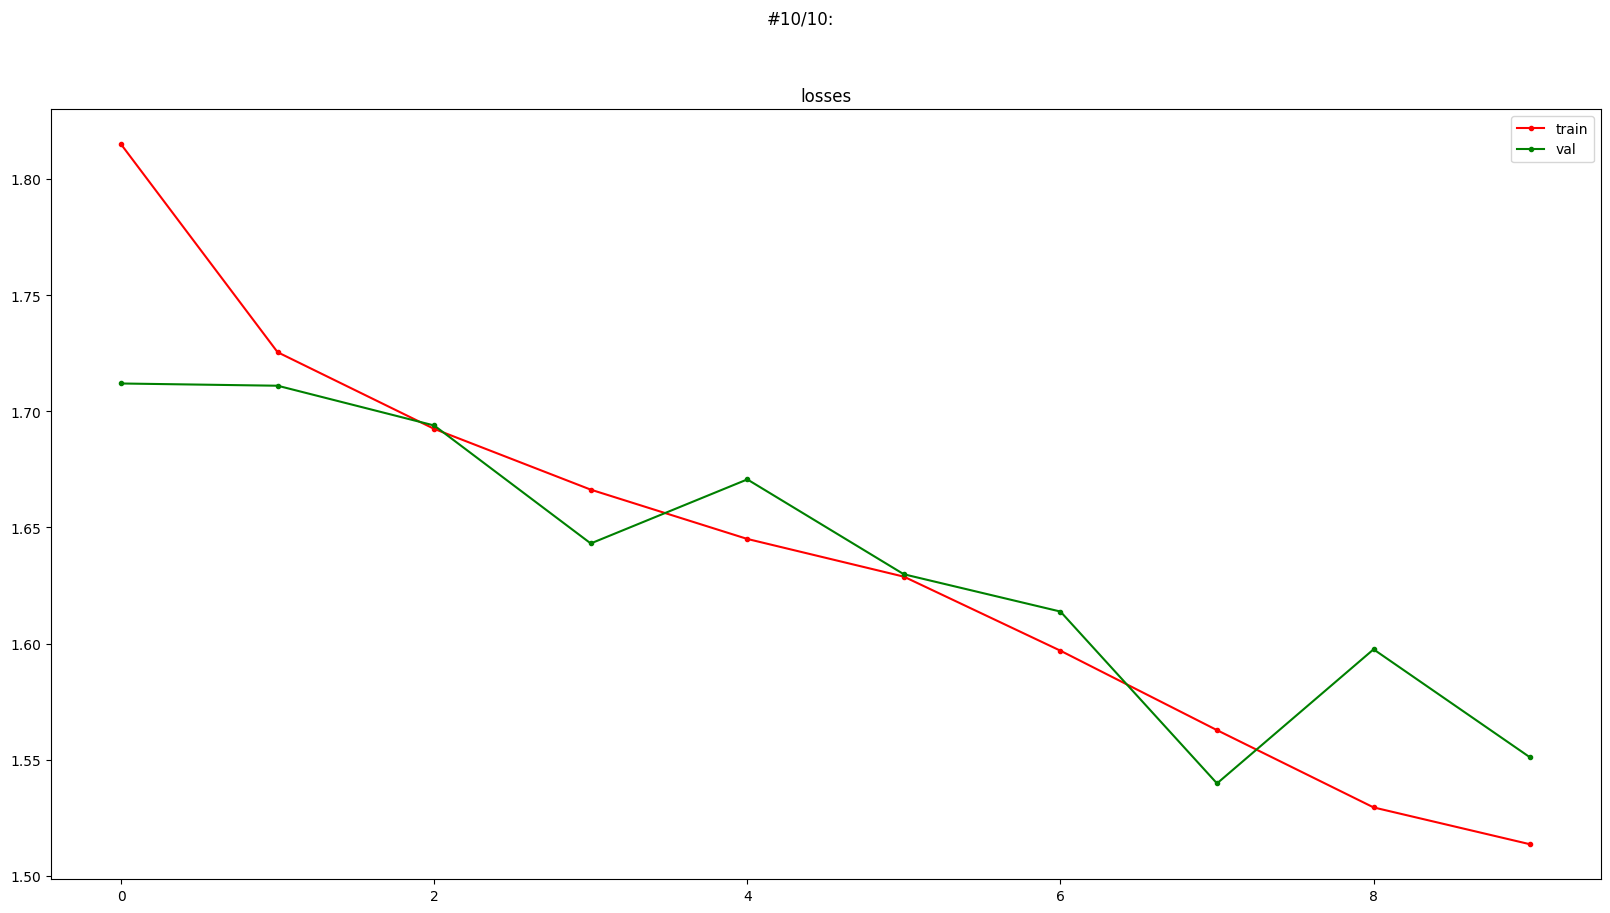

In [32]:
chosen_dataset = 'CIFAR10'
model_type = 'conv_easy'
imgs_batch, lbls_batch = next(iter(dataloaders[chosen_dataset]))
num_classes = len(classes[chosen_dataset])

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

model_params[model_type] = {
    'input_size': imgs_batch.shape[1:],
    'num_layers': 3,
    'kernel_sizes': 5,
    'hidden_sizes': [16, 16, 8],
    'activations': nn.Tanh(),
    'dropouts': 0.2,
    'output_size': num_classes
}

model[model_type], optimizer[model_type] = create_model_and_optimizer(
    model_class = conv_net, 
    model_params = model_params[model_type],
    lr = 5e-4,
    device = device,
)

scheduler[model_type] = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer[model_type], mode='min', factor=0.25, patience=4, threshold=0.001, verbose=True)

criterion[model_type] = nn.NLLLoss()

model[model_type], optimizer[model_type], losses[model_type] = learning_loop(
    model = model[model_type],
    optimizer = optimizer[model_type],
    train_loader = dataloaders[chosen_dataset],
    val_loader = val_dataloaders[chosen_dataset],
    criterion = criterion[model_type],
    scheduler = scheduler[model_type],
    epochs = 10,
    min_lr = 1e-5
)

  0%|          | 0/625 [00:00<?, ?it/s]

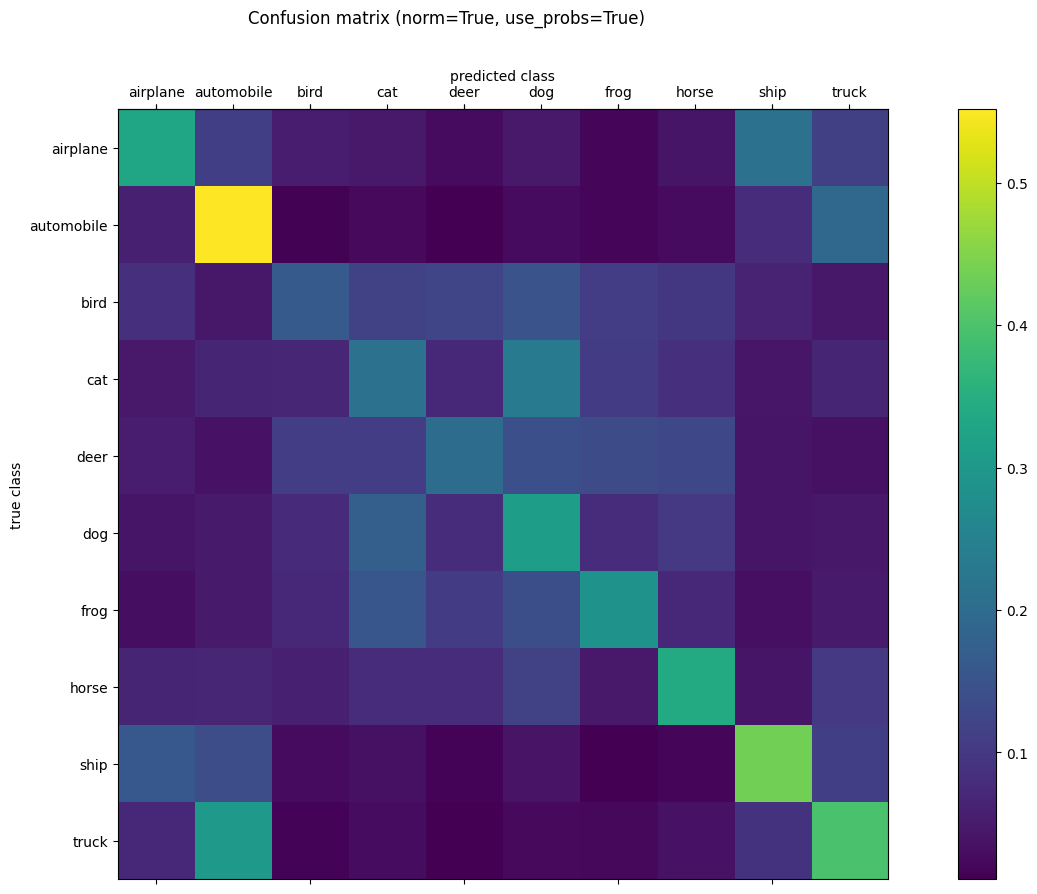

In [33]:
#!g1.2
pcm = real_confusion_matrix(model[model_type], val_dataloaders[chosen_dataset], classes[chosen_dataset], use_probs=True, normalize=True)

## 6. Analyzing results

Few good links

https://distill.pub/2017/feature-visualization $\longrightarrow$ feature visualization

https://yosinski.com/deepvis $\longrightarrow$ deep visualisation toolbox

https://www.programmersought.com/article/23176813233 $\longrightarrow$ visualize the features of CNN

In [35]:
mt_conv = 'conv_easy'

### 6.2 Convolutional internal representations

In [36]:
model[mt_conv]

conv_net(
  (net): Sequential(
    (conv_0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (act_1): Tanh()
    (drop_1): Dropout(p=0.2, inplace=False)
    (conv_1): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (act_2): Tanh()
    (drop_2): Dropout(p=0.2, inplace=False)
    (conv_2): Conv2d(16, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (act_3): Tanh()
    (drop_3): Dropout(p=0.2, inplace=False)
    (flat): Flatten(start_dim=1, end_dim=-1)
    (hid2out): Linear(in_features=8192, out_features=10, bias=True)
    (log-softmax): LogSoftmax(dim=-1)
  )
)

In [37]:
for name, param in list(model[mt_conv].named_parameters()):
    print(name, '\n', param.shape)

net.conv_0.weight 
 torch.Size([16, 3, 5, 5])
net.conv_0.bias 
 torch.Size([16])
net.conv_1.weight 
 torch.Size([16, 16, 5, 5])
net.conv_1.bias 
 torch.Size([16])
net.conv_2.weight 
 torch.Size([8, 16, 5, 5])
net.conv_2.bias 
 torch.Size([8])
net.hid2out.weight 
 torch.Size([10, 8192])
net.hid2out.bias 
 torch.Size([10])


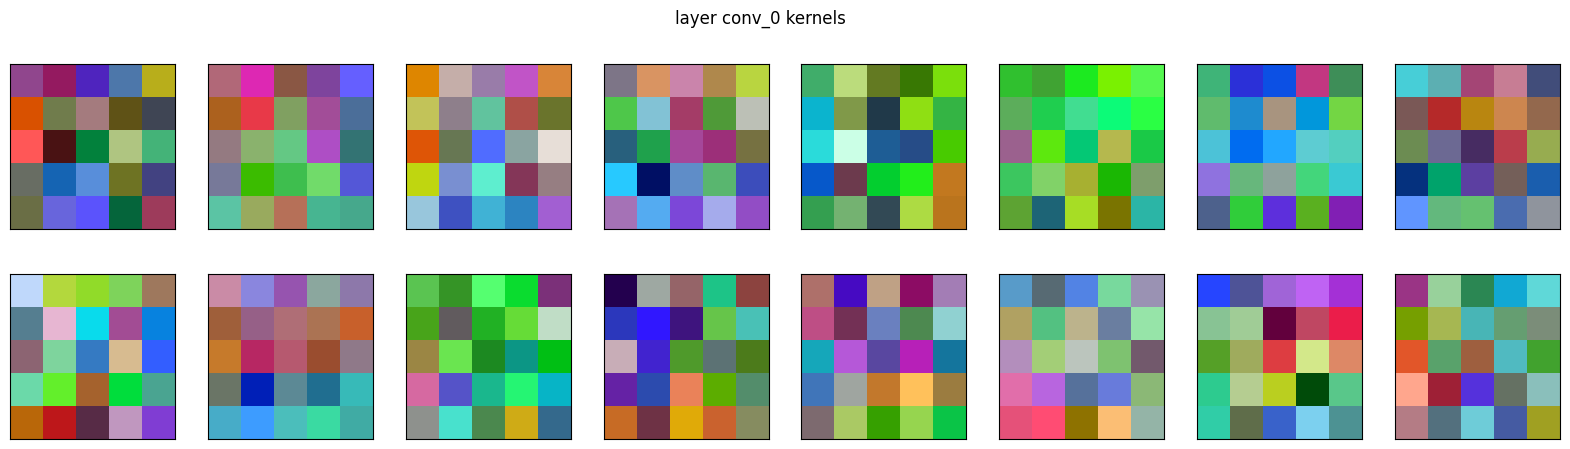

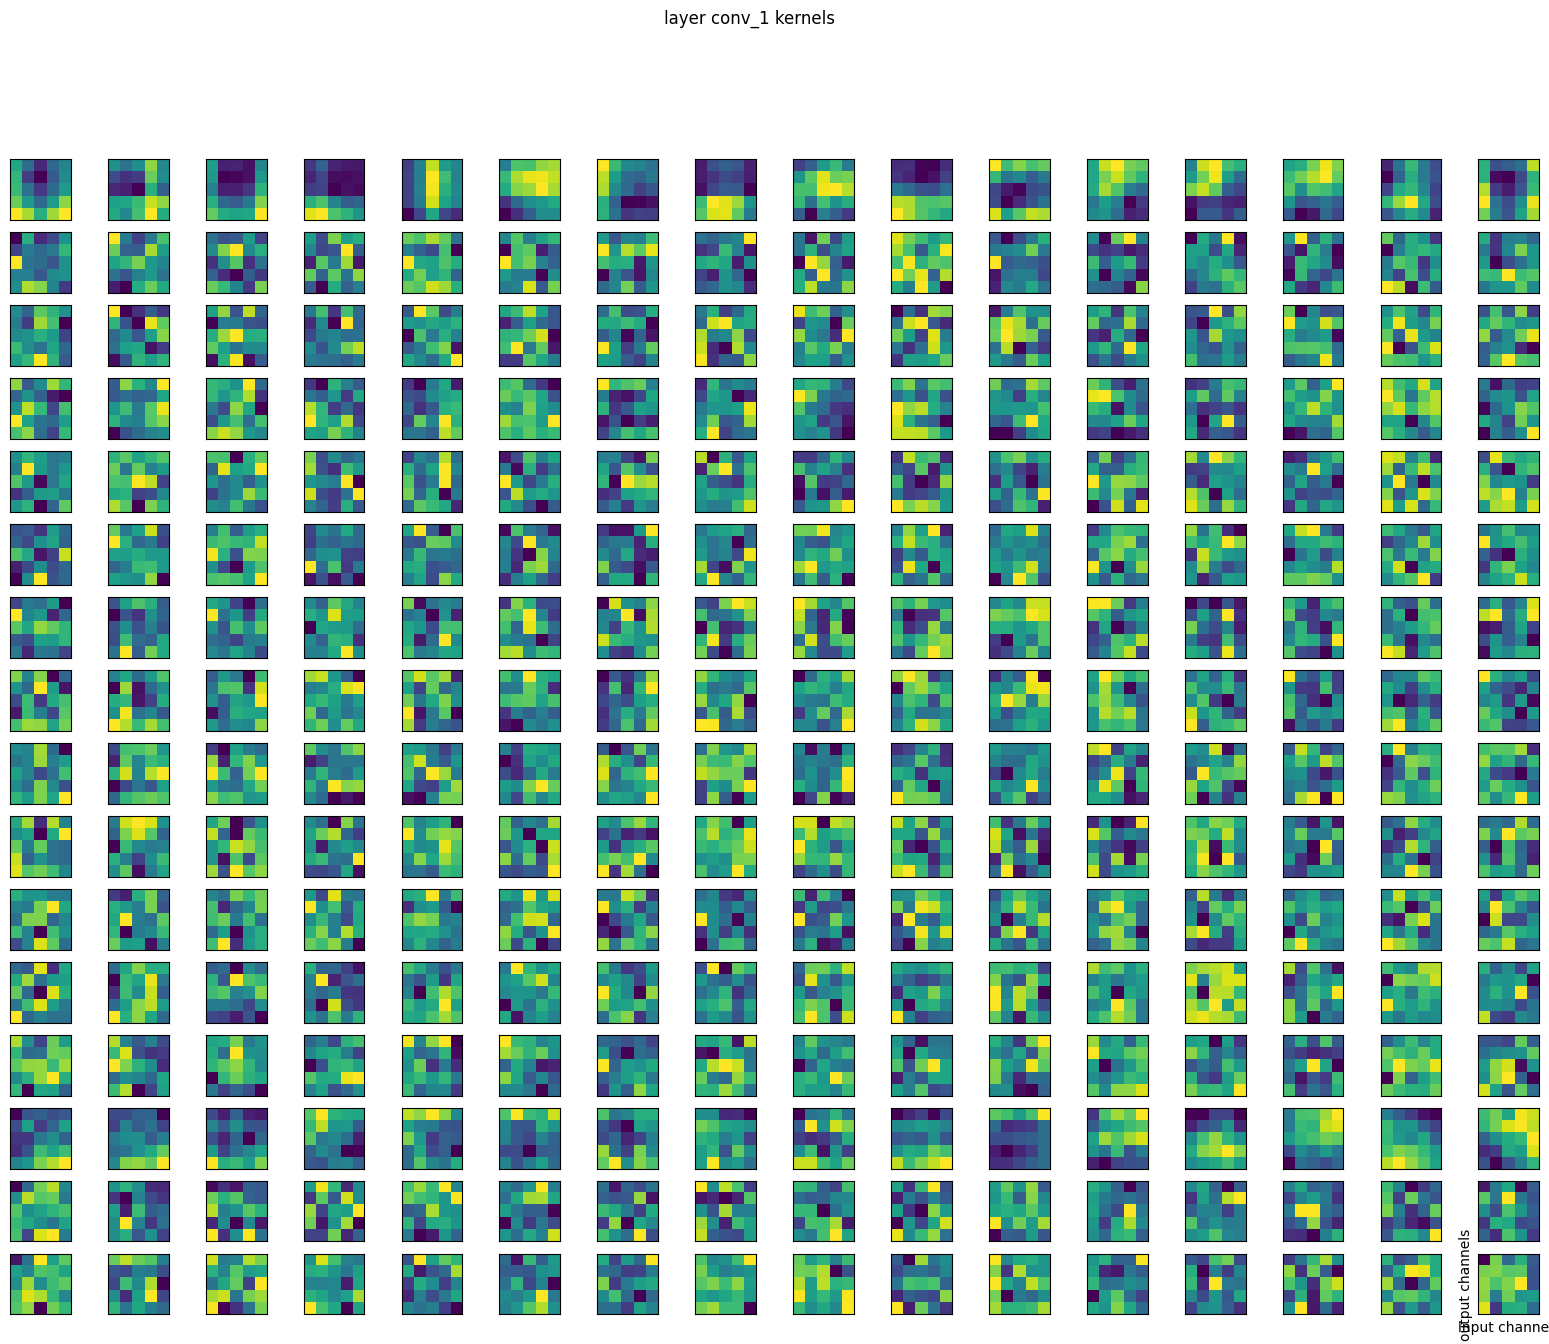

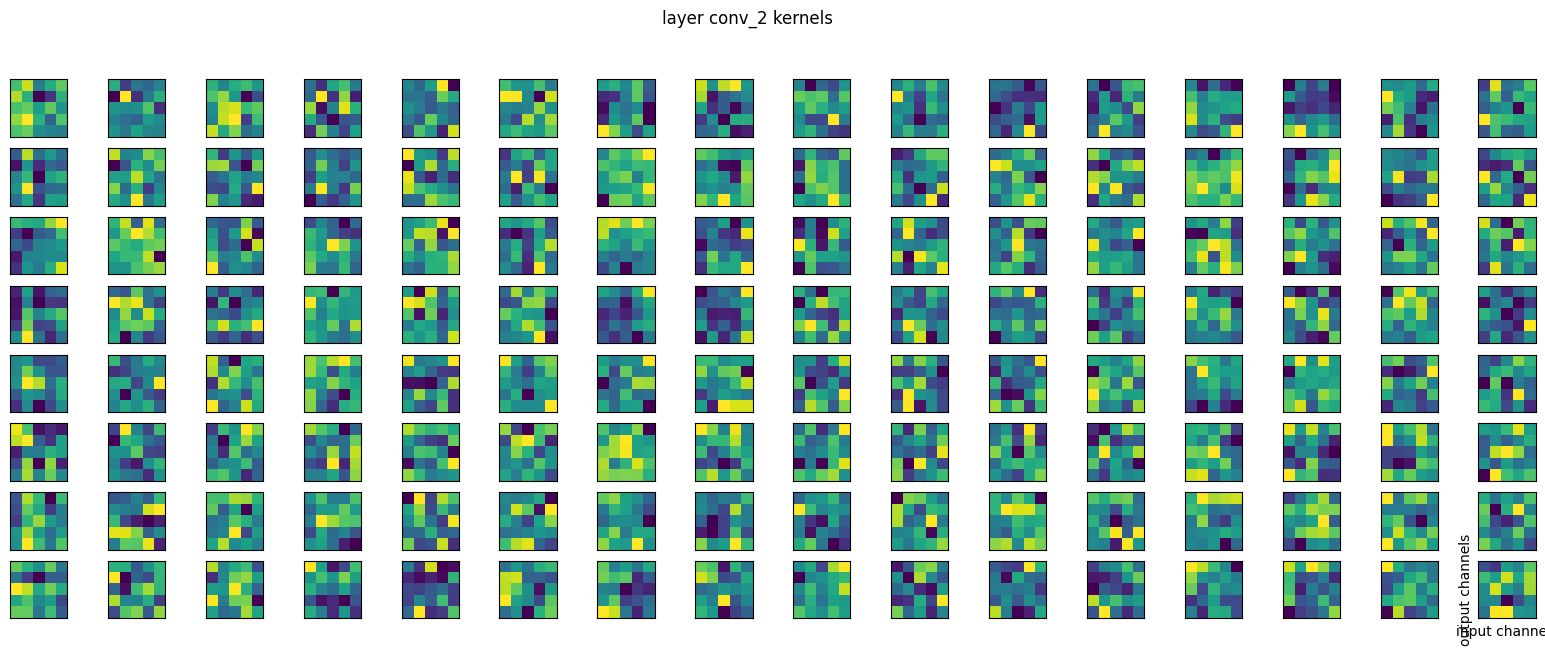

In [42]:
def conv_kernels(conv_model):
    with torch.no_grad():
        first = True
        for name, param in list(conv_model.named_parameters()):
            sp = name.split('.')
            np_data = np.copy(param.data.cpu().numpy())
            if sp[-1] == 'weight' and 'conv' in sp[1]:
                if first:
                    W = 8
                    H = np.ceil(np_data.shape[0] / W).astype(int)
                    fig, ax = plt.subplots(H, W, figsize=(20, 5))
                    fig.suptitle(f'layer {sp[1]} kernels')
                    for img_i in range(np_data.shape[0]):
                        plt.subplot(H, W, img_i+1)
                        plt.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
                        img_ = np_data[img_i].transpose(1, 2, 0)
                        img_ -= np.min(img_)
                        img_ /= np.max(img_)
                        plt.imshow(img_)
                    plt.show()
                    first = False
                else:
                    H = np_data.shape[0]
                    W = np_data.shape[1]
                    fig, ax = plt.subplots(H, W, figsize=(20, H - 1))
                    fig.suptitle(f'layer {sp[1]} kernels')
                    plt.xlabel('input channels')
                    plt.ylabel('output channels')
                    
                    for i in range(H):
                        for j in range(W):
                            plt.subplot(H, W, i*W + j + 1)
                            plt.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
                            plt.imshow(np_data[i, j])
                    plt.show()

conv_kernels(model[mt_conv])

## 7. What else can we do to improve convolutional model's quality?

### 7.1 Image preprocessing

Data preprocessings and augumentations are very important

Always think about how this exact transformation will affect input image and would this help or not

https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py $\longrightarrow$ examples

https://pytorch.org/vision/stable/transforms.html $\longrightarrow$ pytorch transforms documentation

- **Normalization** $\longrightarrow$ extremely important in terms of learning stability
- **Resize** $\longrightarrow$ can be used in a lot of various ways, but most oftenly used to make all the
- **Crops**
- **Flips**
- **Blur**
- **Turn**
- **Grayscale**
- **Brightness/colors/...**

### 7.2 Special tricks

- **Residual connections** $\longrightarrow$ especially important for deep NN, helps avoiding vanishing gradient
- **Layer normalization** $\longrightarrow$ helps avoiding exploding or vanishing gradients, makes learning more stable
- **Max/average poolings** $\longrightarrow$ computationally cheap and easy way of reducing dimensionality of current image, while preserving data. Also is non-linear layer, works really well (emperically) with ReLU activations
- **Global poolings** $\longrightarrow$ can be used instead of flatten + linear head, in terms of convNN is's bettter, because logically it's more important if we found the pattern or not, instead of is's final position. Second important advantage of global pooling - input images can be not of the same size. Also all benefits of poolings are still applied here
- **Adding random noise to the image** $\longrightarrow$ regularization technique

### 7.3 Finetuning & Transfer learning

We can take some big and already trained model (e.g. resnet) and finetune it

**Finetuning** $\longrightarrow$ initializing model from model already trained on simmiliar task with (may be) additional head at the end, then training this model with lower learning rate on our data

Or we can use transfer learning

**Transfer learning** $\longrightarrow$ removing head, freezing most of the parameters (may be except a few last layers) and changing the head to our needs. Then training this model (but in fact just the new head) on our data